In [1]:
# 📦 Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
print("Downloading stock data...")
data = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
data.to_csv("../data/apple_stock.csv")
print("Data saved to data/apple_stock.csv")

data.head()

C:\Users\Chaithanya\AppData\Local\Temp\ipykernel_8504\1515177119.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Data saved to data/apple_stock.csv


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400
2015-01-05,23.577576,24.110152,23.391175,24.030265,257142000
2015-01-06,23.579792,23.839422,23.218083,23.641926,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829126,24.886823,24.121244,24.238856,237458000


Linear Regression MSE: 7.716561370767667


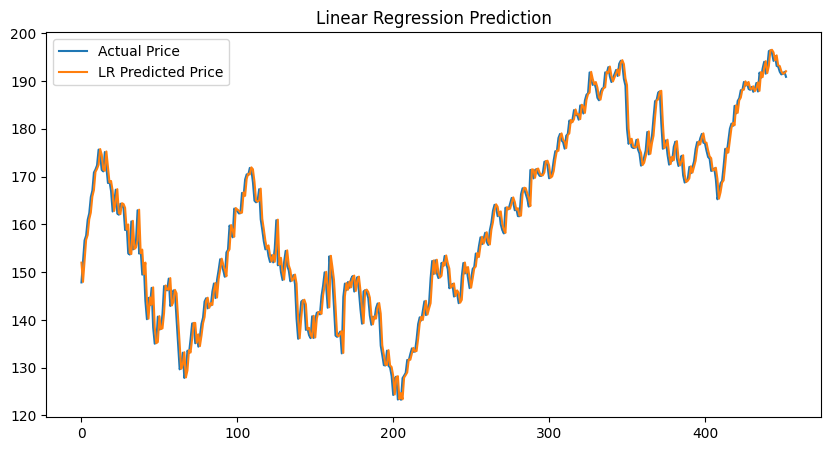

In [3]:
df = data[['Close']].reset_index()
df['Target'] = df['Close'].shift(-1)
df = df.dropna()

X = np.array(df[['Close']])
y = np.array(df['Target'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

print("Linear Regression MSE:", mean_squared_error(y_test, lr_predictions))

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Price")
plt.plot(lr_predictions, label="LR Predicted Price")
plt.title("Linear Regression Prediction")
plt.legend()
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_lstm, y_lstm = create_dataset(scaled, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


In [5]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step,1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, verbose=1)


C:\Users\Chaithanya\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0142
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 6.7885e-04
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 4.2748e-04
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.8128e-04
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.7986e-04


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


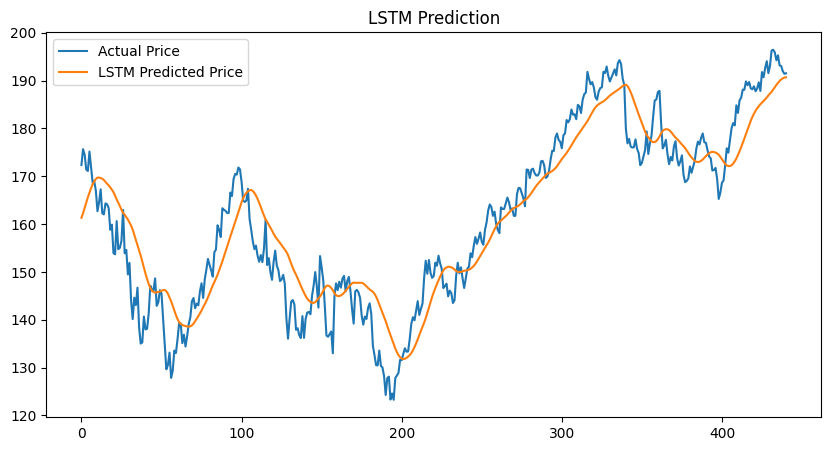

In [6]:
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(y_test_lstm.reshape(-1,1)), label="Actual Price")
plt.plot(lstm_predictions, label="LSTM Predicted Price")
plt.title("LSTM Prediction")
plt.legend()
plt.show()
